In [344]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)

# Setting up device agnostic code to use CUDA
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

2.1.0+cu121
cuda:0


## Data Preparation

In [345]:
weights = 0.7
bias = 0.3

start, end, step = 0, 1, 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weights * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [346]:
# Split train/test data
train_split = int(0.8* len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train),len( y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [347]:
# Plot prediction function
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):

  plt.figure(figsize=(8, 4))

  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 10});

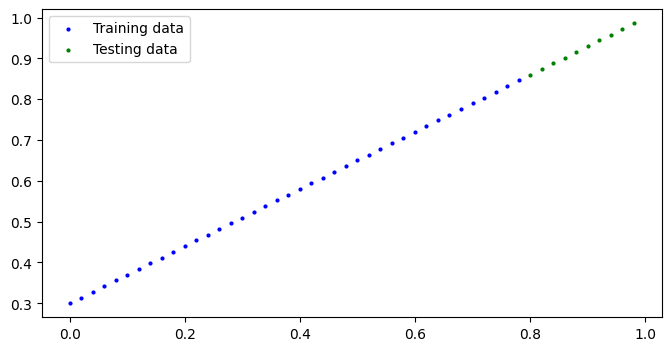

In [348]:
plot_predictions()

## Build Linear PyTorch Model

In [349]:
class LinearRegressionV2(nn.Module):
  def __init__(self):
    super().__init__()

    # Using nn.linear() for model parameters
    self.linear = nn.Linear(in_features = 1,
                            out_features = 1)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear(x)     # In built Linear Regression NN

# For reproducibility
torch.manual_seed(42)
model = LinearRegressionV2()

model, model.state_dict()

(LinearRegressionV2(
   (linear): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear.weight', tensor([[0.7645]])),
              ('linear.bias', tensor([0.8300]))]))

In [350]:
# Checking current device
next(model.parameters()).device

device(type='cpu')

In [351]:
# Set model usage to CUDA
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

## Train

In [352]:
# Creating loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(params = model.parameters(),
                            lr = 0.01)

In [353]:
torch.manual_seed(42)

epochs = 250

# Placing data on CUDA
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Tracking
epoch_count = []
loss_values = []
test_loss_values = []

# Train loop
for epoch in range(epochs):
  model.train()
  y_pred = model(X_train)
  loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model.eval()
  with torch.inference_mode():
    test_pred = model(X_test)
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 100 == 0 or epoch == epochs-1:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f'Epoch: {epoch} | Train Loss: {loss:.4f} | Test Loss: {test_loss:.4f}')

print('=' * 50)
print('Original values of weights and bias:',weights, 'and', bias)
print(model.state_dict())

Epoch: 0 | Train Loss: 0.5552 | Test Loss: 0.5685
Epoch: 100 | Train Loss: 0.0150 | Test Loss: 0.0290
Epoch: 200 | Train Loss: 0.0018 | Test Loss: 0.0014
Epoch: 249 | Train Loss: 0.0005 | Test Loss: 0.0030
Original values of weights and bias: 0.7 and 0.3
OrderedDict([('linear.weight', tensor([[0.7026]], device='cuda:0')), ('linear.bias', tensor([0.3007], device='cuda:0'))])


## Loss Curves



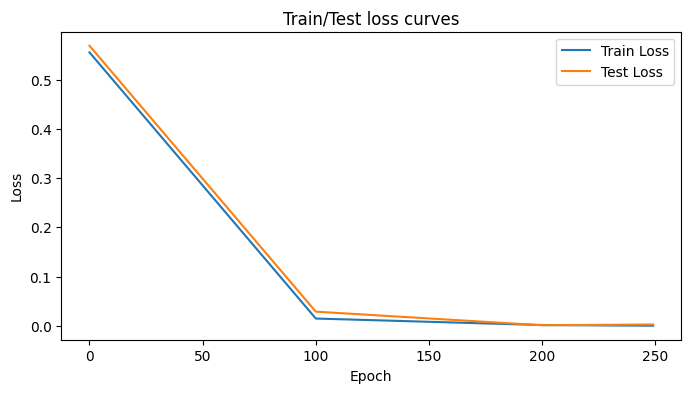

In [354]:
# Plot loss curves
plt.figure(figsize=(8,4))
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test Loss")
plt.title("Train/Test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend();

## Making Predictions

In [355]:
model.eval()

with torch.inference_mode():
  y_preds = model(X_test)

y_preds

tensor([[0.8627],
        [0.8768],
        [0.8908],
        [0.9049],
        [0.9189],
        [0.9330],
        [0.9470],
        [0.9611],
        [0.9752],
        [0.9892]], device='cuda:0')

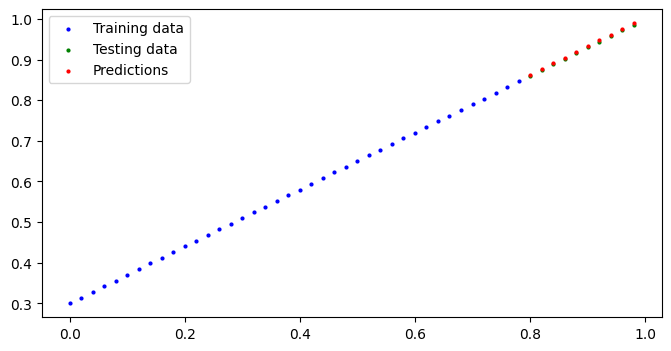

In [356]:
# Note: Plot doesnt work in GPU so transfering to cpu
plot_predictions(predictions = y_preds.to('cpu'))

## Saving and Loading a model

In [357]:
from pathlib import Path

model_path = Path('models')
model_path.mkdir(parents = True, exist_ok =True)

model_name = '01_LinearRegressionV2.pth'
model_save_path = model_path / model_name

print(f"Saving model to: {model_save_path}")
torch.save(obj = model.state_dict(),
           f = model_save_path)
print('Saved Successfully')

Saving model to: models/01_LinearRegressionV2.pth
Saved Successfully


In [358]:
loaded_model = LinearRegressionV2()
loaded_model.load_state_dict(torch.load(model_save_path))

# Transfer loaded model to CUDA
loaded_model.to(device)

print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:\n{next(loaded_model.parameters()).device}")

Loaded model:
LinearRegressionV2(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [359]:
# Evaluate loaded model
loaded_model.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model(X_test)

y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')